# Windfields

This notebook is for downloading typhoon tracks from
IBTrACS and generating the windfields.

TODOs:

- Get the full list of track IDs from IBTraCS (link is below)
- Add interpolation between the timesteps
- Understand if we need to change any of the input parameters
  to the climada methods
- Aggregate up to a 0.1 deg grid and save output

In [35]:
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [36]:
import pandas as pd
import numpy as np
import xarray as xr

# import datetime

from climada.hazard import Centroids, TCTracks, TropCyclone

In [37]:
help(TCTracks.from_ibtracs_netcdf)

Help on method from_ibtracs_netcdf in module climada.hazard.tc_tracks:

from_ibtracs_netcdf(provider=None, rescale_windspeeds=True, storm_id=None, year_range=None, basin=None, genesis_basin=None, interpolate_missing=True, estimate_missing=False, correct_pres=False, discard_single_points=True, file_name='IBTrACS.ALL.v04r00.nc') method of builtins.type instance
    Create new TCTracks object from IBTrACS databse.
    
    When using data from IBTrACS, make sure to be familiar with the scope and limitations of
    IBTrACS, e.g. by reading the official documentation
    (https://www.ncdc.noaa.gov/ibtracs/pdf/IBTrACS_version4_Technical_Details.pdf). Reading the
    CLIMADA documentation can't replace a thorough understanding of the underlying data. This
    function only provides a (hopefully useful) interface for the data input, but cannot
    provide any guidance or make recommendations about if and how to use IBTrACS data for your
    particular project.
    
    Resulting tracks are req

Mersedeh:

I would browse [here](https://ncics.org/ibtracs/index.php?name=browse-name)
to create a list of the event IDs that we want. Here I made a start:

In [38]:
new_typhoon_id_dict = {}
# Typhoons' name and Id
typhoon_id_dict = {
    "2006329N06150": "DURIAN",
    "2008169N08135": "FENGSHEN",
    "2009268N14128": "KETSANA",
    "2010191N12138": "CONSON",
    "2011266N13139": "NESAT",
    "2012331N03157": "BOPHA",
    "2013282N14132": "NARI",
    "2013301N13142": "KROSA",
    "2013306N07162": "HAIYAN",
    "2013259N17132": "USAGI",
    "2013220N12137": "UTOR",
    "2014362N07130": "JANGMI",
    "2014254N10142": "KALMAEGI",
    "2014190N08154": "RAMMASUN",
    "2014334N02156": "HAGUPIT",
    "2014260N13135": "FUNG-WONG",
    "2014015N10129": "LINGLING",
    "2015273N12130": "MUJIGAE",
    "2015344N07145": "MELOR",
    "2015122N07144": "NOUL",
    "2015226N12151": "GONI",
    "2015183N13130": "LINFA",
    "2015285N14151": "KOPPU",
    "2015012N09146": "MEKKHALA",
    "2016288N07145": "HAIMA",
    "2016328N09130": "TOKAGE",
    "2016253N13144": "MERANTI",
    "2016355N07146": "NOCK-TEN",
    "2016287N13130": "SARIKA",
    "2018250N12170": "MANGKHUT",
    "2018294N08161": "YUTU",
    "2019329N09160": "KAMMURI",
    "2019308N13114": "NAKRI",
    "2019354N05151": "PHANFONE",
    "2020291N06141": "SAUDEL",
    "2020299N11144": "GONI",
    "2020313N08135": "VAMCO",
    "2020129N07134": "VONGFONG",
    "2020296N09137": "MOLAVE",
}

for i in range(len(typhoon_id_dict)):

    # n_key = list(typhoon_id_dict.keys())[i]
    typhoon_year = list(typhoon_id_dict.keys())[i][0:4]
    new_key = list(typhoon_id_dict.values())[i] + typhoon_year
    new_typhoon_id_dict[new_key] = list(typhoon_id_dict.keys())[i]

print(new_typhoon_id_dict)

{'DURIAN2006': '2006329N06150', 'FENGSHEN2008': '2008169N08135', 'KETSANA2009': '2009268N14128', 'CONSON2010': '2010191N12138', 'NESAT2011': '2011266N13139', 'BOPHA2012': '2012331N03157', 'NARI2013': '2013282N14132', 'KROSA2013': '2013301N13142', 'HAIYAN2013': '2013306N07162', 'USAGI2013': '2013259N17132', 'UTOR2013': '2013220N12137', 'JANGMI2014': '2014362N07130', 'KALMAEGI2014': '2014254N10142', 'RAMMASUN2014': '2014190N08154', 'HAGUPIT2014': '2014334N02156', 'FUNG-WONG2014': '2014260N13135', 'LINGLING2014': '2014015N10129', 'MUJIGAE2015': '2015273N12130', 'MELOR2015': '2015344N07145', 'NOUL2015': '2015122N07144', 'GONI2015': '2015226N12151', 'LINFA2015': '2015183N13130', 'KOPPU2015': '2015285N14151', 'MEKKHALA2015': '2015012N09146', 'HAIMA2016': '2016288N07145', 'TOKAGE2016': '2016328N09130', 'MERANTI2016': '2016253N13144', 'NOCK-TEN2016': '2016355N07146', 'SARIKA2016': '2016287N13130', 'MANGKHUT2018': '2018250N12170', 'YUTU2018': '2018294N08161', 'KAMMURI2019': '2019329N09160', 'NA

In [39]:
# Download all tracks from the west pacific basin
sel_ibtracs = TCTracks.from_ibtracs_netcdf(
    provider="usa", year_range=(2006, 2022), basin="WP"
)

2022-11-22 13:58:36,600 - climada.hazard.tc_tracks - WARNING - 18 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


In [40]:
# Look at how many tracks there are - there are a lot
sel_ibtracs.size

494

In [41]:
# get_track returns the first matching track based on the assumption that no other track with the same name exists in the set
# Loop through the typhoons
tc_tracks = TCTracks()
for typhoon_id in new_typhoon_id_dict.values():
    tc_track = sel_ibtracs.get_track(typhoon_id)
    # TODO: We need to add a step here that interpolates the time
    tc_tracks.append(tc_track)

display(tc_tracks.data)

[<xarray.Dataset>
 Dimensions:                 (time: 123)
 Coordinates:
   * time                    (time) datetime64[ns] 2006-11-24T12:00:00 ... 200...
     lat                     (time) float32 6.1 6.21 6.4 6.72 ... 11.5 11.59 11.7
     lon                     (time) float32 149.8 149.3 148.8 ... 83.3 82.59 81.8
 Data variables:
     time_step               (time) float64 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0
     radius_max_wind         (time) float32 0.0 0.0 0.0 40.0 ... 0.0 0.0 0.0 0.0
     radius_oci              (time) float32 0.0 0.0 0.0 150.0 ... 0.0 0.0 0.0 0.0
     max_sustained_wind      (time) float32 15.0 15.0 15.0 ... 15.0 15.0 15.0
     central_pressure        (time) float32 1.006e+03 1.006e+03 ... 1.006e+03
     environmental_pressure  (time) float64 1.008e+03 1.008e+03 ... 1.006e+03
     basin                   (time) <U2 'WP' 'WP' 'WP' 'WP' ... 'NI' 'NI' 'NI'
 Attributes:
     max_sustained_wind_unit:  kn
     central_pressure_unit:    mb
     name:                 

In [42]:
# display(tc_tracks.data[0]["time"])

In [43]:
# type(tc_tracks.data)

In [44]:
# sel_ibtracs.get_track("2015226N12151")
len(tc_tracks.data)

39

In [45]:
tc_track_list = TCTracks()
for i in range(len(tc_tracks.data)):

    df_1 = tc_tracks.data[i].to_dataframe()

    df_1 = df_1.resample("30T").interpolate()
    df_1["basin"] = df_1["basin"].ffill()

    # display(df_1)

    tc_track_1 = xr.Dataset(
        data_vars={
            "radius_max_wind": df_1["radius_max_wind"].to_numpy(),
            "radius_oci": df_1["radius_oci"].to_numpy(),
            "max_sustained_wind": df_1["max_sustained_wind"].to_numpy(),
            "environmental_pressure": df_1[
                "environmental_pressure"
            ].to_numpy(),
            "time_step": df_1["time_step"].to_numpy(),
            "central_pressure": df_1["central_pressure"].to_numpy(),
            "basin": df_1["basin"].to_numpy(),
        },
        coords={
            "time": df_1.index.to_numpy(),
            "lat": df_1["lat"].to_numpy(),
            "lon": df_1["lon"].to_numpy(),
        },
        attrs={
            "max_sustained_wind_unit": tc_tracks.data[i].attrs[
                "max_sustained_wind_unit"
            ],
            "central_pressure_unit": tc_tracks.data[i].attrs[
                "central_pressure_unit"
            ],
            "name": tc_tracks.data[i].attrs["name"],
            "sid": tc_tracks.data[i].attrs["sid"],
            "orig_event_flag": tc_tracks.data[i].attrs["orig_event_flag"],
            "data_provider": tc_tracks.data[i].attrs["data_provider"],
            "id_no": tc_tracks.data[i].attrs["id_no"],
            "category": tc_tracks.data[i].attrs["category"],
        },
    )

    tc_track_list.append(tc_track_1)
display(tc_track_list)

In [46]:
tc_track_list.data

[<xarray.Dataset>
 Dimensions:                 (radius_max_wind: 733, radius_oci: 733,
                              max_sustained_wind: 733,
                              environmental_pressure: 733, time_step: 733,
                              central_pressure: 733, basin: 733, time: 733,
                              lat: 733, lon: 733)
 Coordinates:
   * radius_max_wind         (radius_max_wind) float32 0.0 0.0 0.0 ... 0.0 0.0
   * radius_oci              (radius_oci) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
   * max_sustained_wind      (max_sustained_wind) float32 15.0 15.0 ... 15.0 15.0
   * environmental_pressure  (environmental_pressure) float64 1.008e+03 ... 1....
   * time_step               (time_step) float64 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0
   * central_pressure        (central_pressure) float32 1.006e+03 ... 1.006e+03
   * basin                   (basin) object 'WP' 'WP' 'WP' ... 'NI' 'NI' 'NI'
   * time                    (time) datetime64[ns] 2006-11-24T12:00:00 ... 200.

# Make Interpolation based on timestep==0.5H instead of 3H

for i in range(len(tc_tracks.data)):

    df_1 = tc_tracks.data[i].to_dataframe()

    # df_1.set_index("time", inplace=True)
    df_1 = df_1.resample("30T").interpolate()
    df_1["basin"] = df_1["basin"].ffill()
    
    tc_tracks.data[i] = tc_tracks.data[i].from_dataframe(df_1)
    # tc_tracks.data[i].concat(combine_attrs="override")

display(tc_tracks.data)

In [49]:
type(tc_track_list)

climada.hazard.tc_tracks.TCTracks

<GeoAxesSubplot:>

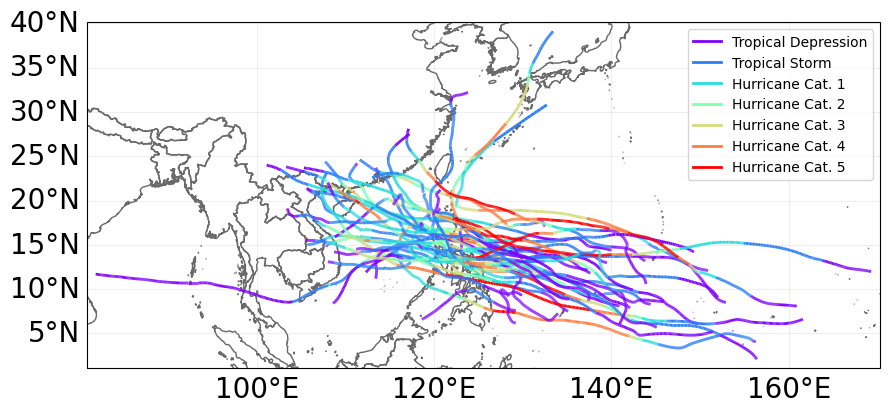

In [52]:
# Plot the tracks
tc_track_list.plot()

In [53]:
help(TropCyclone.from_tracks)

Help on method from_tracks in module climada.hazard.trop_cyclone:

from_tracks(tracks, centroids=None, pool=None, description='', model='H08', ignore_distance_to_coast=False, store_windfields=False, metric='equirect', intensity_thres=17.5) method of builtins.type instance
    Create new TropCyclone instance that contains windfields from the specified tracks.
    
    This function sets the `intensity` attribute to contain, for each centroid,
    the maximum wind speed (1-minute sustained winds at 10 meters above ground) experienced
    over the whole period of each TC event in m/s. The wind speed is set to 0 if it doesn't
    exceed the threshold `intensity_thres`.
    
    The `category` attribute is set to the value of the `category`-attribute
    of each of the given track data sets.
    
    The `basin` attribute is set to the genesis basin for each event, which
    is the first value of the `basin`-variable in each of the given track data sets.
    
    Optionally, the time depend

2022-11-22 14:03:19,508 - climada.util.plot - WARNING - Error parsing coordinate system 'EPSG:4326'. Using projection PlateCarree in plot.


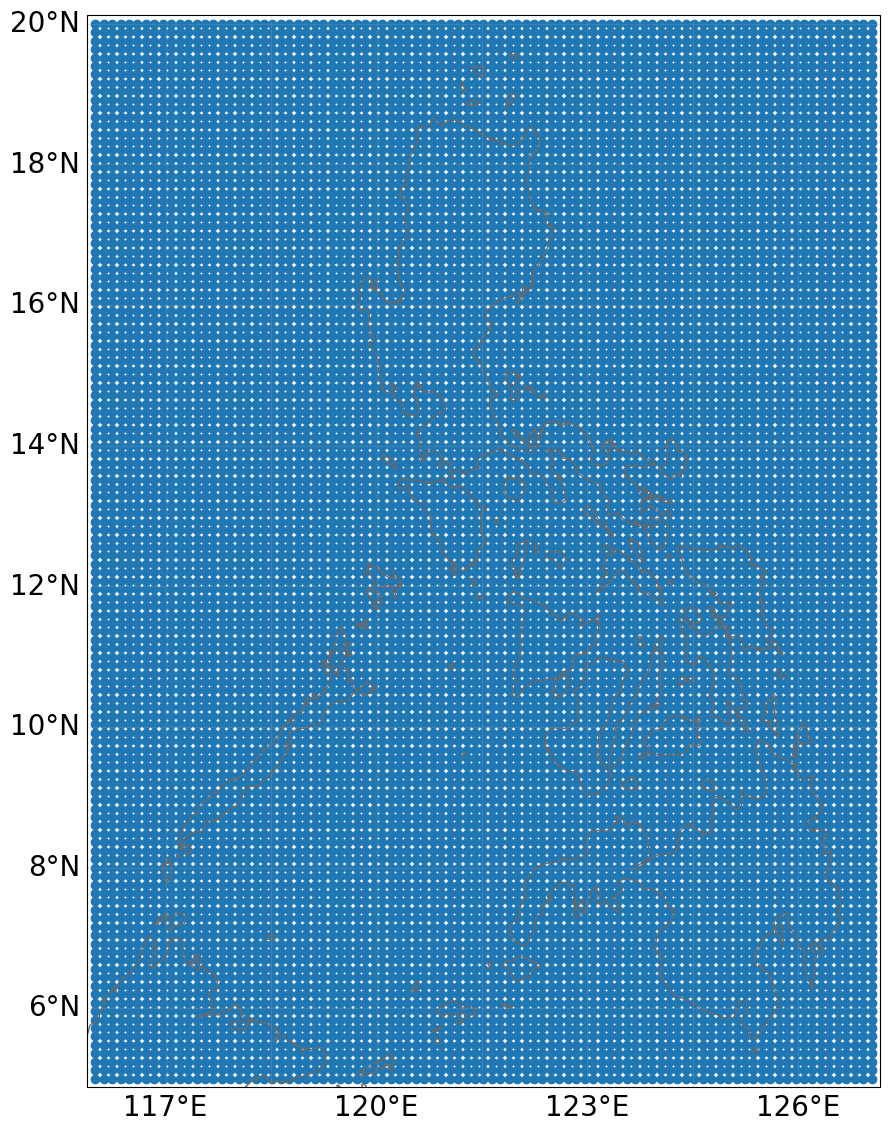

In [54]:
# construct centroids
min_lat, max_lat, min_lon, max_lon = 5.0, 20.0, 116.0, 127.0  # TODO: Adjust
cent = Centroids.from_pnt_bounds(
    (min_lon, min_lat, max_lon, max_lat), res=0.12
)
cent.check()
cent.plot();

In [56]:
# construct tropical cyclones
tc = TropCyclone.from_tracks(
    tc_track_list, centroids=cent, store_windfields=True
)

2022-11-22 14:05:03,417 - climada.util.plot - WARNING - Error parsing coordinate system 'EPSG:4326'. Using projection PlateCarree in plot.


<GeoAxesSubplot:title={'center':'Event ID 7: 2013282N14132'}>

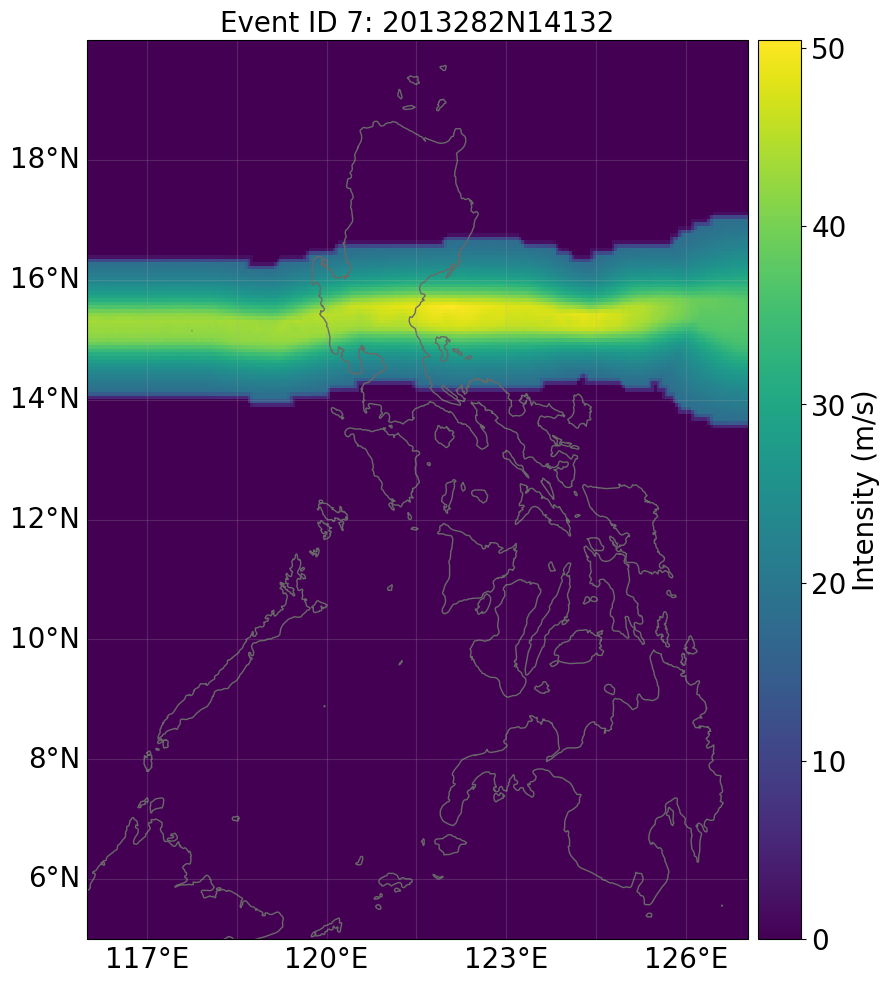

In [57]:
# Let's look at the first typhoon in the dictionary as an example.

tc.plot_intensity(new_typhoon_id_dict["NARI2013"])

In [58]:
# Then calculate windfield
intensity = tc.intensity

In [59]:
tc.intensity

<39x11718 sparse matrix of type '<class 'numpy.float64'>'
	with 81390 stored elements in Compressed Sparse Row format>

In [60]:
windfield_data = intensity.data
windfield_data

array([18.47241286, 18.15957914, 17.8690079 , ..., 17.65572339,
       17.97236532, 17.68126776])

In [61]:
import scipy.sparse

scipy.sparse.save_npz("sparse_matrix.npz", tc.intensity, compressed=True)

In [62]:
sparse_matrix = scipy.sparse.load_npz("sparse_matrix.npz")

In [63]:
sparse_matrix.toarray()

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [29.7217212 , 29.82215779, 29.39314909, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])